# Análisis de la sensibilidad en la topología Sallen-Key

<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Por Mariano Llamedo Soria

### Introducción


En el siguiente documento analizaremos la dispersión de parámetros $Q$, $\omega_0$ y la ganancia $K$ correspondiente a una topología Sallen-Key en su configuración pasabajo

<img src="./sallenkey.png" align="center" width="700" style="border:10px solid white" /> 

Comenzaremos analizando las ecuaciones que gobiernan el comportamiento de la red:





 1. Nodo $V_b$
 
  $ V_b . (G_1 + G_2 + s.C) - V_i . G_1 - V_a . G_2  - V_o . s.C = 0$


 2. Nodo $V_a$ ó $V_+$
 
  $ -V_b . G_2 + V_a . (G_2 + s.C) = 0$


 3. Nodo $V_-$
 
  $ V_- . (G_a + G_b) - V_o . G_b = 0$


Si consideramos que la red está **realimentada negativamente**, podemos agregar la siguiente ecuación:


 4. $V_- = V_+ = V_a$
 
  
y proceder a resolver el sistema de ecuaciones para $\frac{V_o}{V_i}$


$$ \omega_0^2=\frac{G_1 G_2}{C^2} $$

$$ K=1+R_B/R_A $$


$$ Q=\frac{ \sqrt{G_1 G_2}}{G_1 + G_2(2-K)} $$



Como se analizó en clase, la transferencia de tensión está definida por la siguiente función

$$ T(s) = \frac{ K·\omega_0^2}{s^2 + s · \omega_0/Q + \omega_0^2} $$

siendo 

$$ \omega_0^2=\frac{G_1 G_2}{C^2} $$

$$ K=1+R_B/R_A $$


$$ Q=\frac{ \sqrt{G_1 G_2}}{G_1 + G_2(2-K)} $$


### Experimentación

Realizaremos un estudio de la dispersión de $Q$, $\omega_0$ y $K$ muestreando valores de $C$, $R$ y $R_B$ de una distribución uniforme, definida por la tolerancia de cada componente. Para ello simulamos el comportamiento de la función transferencia mediante Python en los siguientes scripts.

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos externos
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import TransferFunction

fig_sz_x = 8
fig_sz_y = 6
fig_dpi = 150 # dpi

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi



In [2]:
# Ahora importamos las funciones de PyTC2

from pytc2.sistemas_lineales import pzmap, GroupDelay, bodePlot, pretty_print_bicuad_omegayq

from pytc2.general import print_subtitle


#### Transferencia sampleada al azar

<IPython.core.display.Math object>

#### Transferencia deseada

<IPython.core.display.Math object>

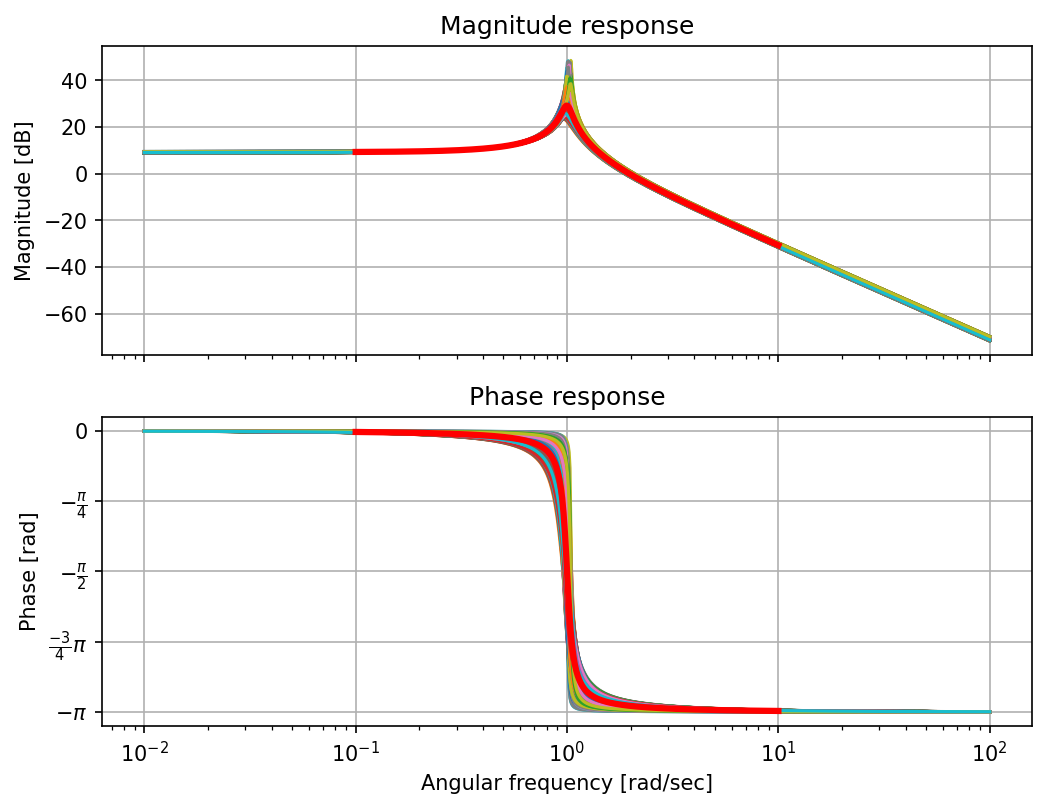

In [3]:
################
## simulación ##
################

# Cantidad de iteraciones o experimentos
NN = 1000
# Tolerancia de los componentes
tol = 5

# Q y \omega_0 proyectados
QQ = 10
W0 = 1

# Valores de los componentes 
CC = 1
RR = 1
RB = (2-1/QQ)*RR

# Valores de los componentes para cada iteración:
# Cada valor es muestreado independientemente de una distribución uniforme,
# limitada por la tolerancia impuesta.
all_C = np.random.uniform(CC * (100-tol/2)/100 , CC * (100+tol/2)/100, size=NN )
all_R = np.random.uniform(RR * (100-tol/2)/100 , RR * (100+tol/2)/100, size=NN )
all_RB = np.random.uniform(RB * (100-tol/2)/100 , RB * (100+tol/2)/100, size=NN )

plt.close('all')

fig_hdl = plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
axes_hdl = fig_hdl.subplots(2, 1, sharex='col')
fig_id = fig_hdl.number

# analizaremos cada iteración resultante
for (this_C, this_R, this_RB) in zip( all_C, all_R, all_RB):

    this_KK = 1 + this_RB/this_R
    this_QQ = 1/(3-this_KK)
    this_w0 = 1/this_R/this_C
    
    num = [this_KK * (this_w0**2)]
    den = [1, this_w0/this_QQ, this_w0**2]
    
    my_tf = TransferFunction( num, den )
    
    _, axes_hdl = bodePlot(my_tf, fig_id)


# visualizamos la última realización a modo de ejemplo
print_subtitle('Transferencia sampleada al azar')

pretty_print_bicuad_omegayq(num,den)

# finalmente ploteamos también la transferencia con los valores esperados
# sin incertidumbre alguna sobre sus valores.
KK = 1 + RB/RR
QQ = 1/(3-KK)
WW0 = 1/RR/CC

num = [KK * (WW0**2)]
den = [1, WW0/QQ, WW0**2]

# visualizamos la transferencia esperada o media
print_subtitle('Transferencia deseada')

pretty_print_bicuad_omegayq(num,den)

my_tf = TransferFunction( num, den )

w, mag, phase = my_tf.bode(n=300)

(mag_ax_hdl, phase_ax_hdl) = axes_hdl

plt.sca(mag_ax_hdl)
plt.semilogx(w, mag, '-r', linewidth=3 )    # Bode magnitude plot
    
plt.sca(phase_ax_hdl)
plt.semilogx(w, phase*np.pi/180, '-r', linewidth=3)    # Bode phase plot

plt.show()


Para luego analizar estadísticamente la distribución de cada parámetro

Text(0.5, 1.0, '$\\omega_0$ para cada experimento')

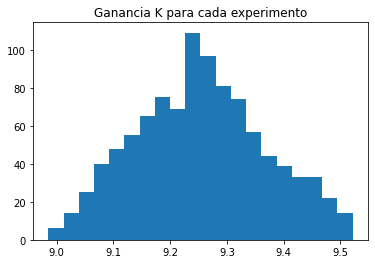

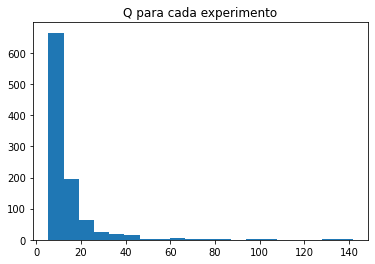

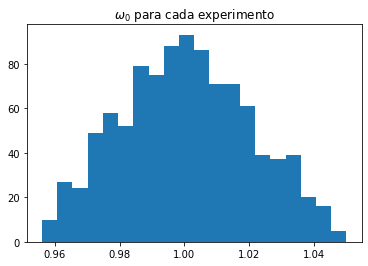

In [4]:
# Ahora vamos a hacer un estudio estadístico de los parámetros Q y \omega_0
# calculo los valores de los parámetros para TODAS las iteraciones
all_KK = 1 + all_RB/all_R
all_QQ = 1/(3-all_KK)
all_w0 = 1/all_R/all_C

#plt.figure(figsize=(fig_sz_x*6/10, fig_sz_y*4/10), dpi= fig_dpi, facecolor='w', edgecolor='k')
plt.figure()
plt.hist( 20*np.log10(all_KK), 20 )
plt.title('Ganancia K para cada experimento')

#plt.figure(figsize=(fig_sz_x*6/10, fig_sz_y*4/10), dpi= fig_dpi, facecolor='w', edgecolor='k')
plt.figure()
plt.hist( all_QQ, 20 )
plt.title('Q para cada experimento')

#plt.figure(figsize=(fig_sz_x*6/10, fig_sz_y*4/10), dpi= fig_dpi, facecolor='w', edgecolor='k')
plt.figure()
plt.hist( all_w0, 20 )
plt.title('$\omega_0$ para cada experimento')


Como se puede ver en los histogramas, el parámetro $Q$ es el más afectado o sensible en esta topología, razón por la cual habrá que ser extremadamente cuidadoso en el diseño de este tipo de redes activas. El $Q$ depende de la ganancia $k$ que a su vez depende de la relación de dos resistores. Esta alta sensibilidad puede mitigarse, o bien utilizando resistores con tolerancias bajas (<= 1%), o asumiendo que el Q a implementar sea bajo de forma tal de relajar el valor de la ganancia a implementar.